In [1]:
import pandas as pd

df = pd.read_csv('pre_data/HousePriceDatasetsCleaned.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20427 entries, 0 to 20426
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   list_time                20427 non-null  object 
 1   area                     20427 non-null  int64  
 2   area_name                20427 non-null  object 
 3   price                    20427 non-null  int64  
 4   price_string             20427 non-null  object 
 5   rooms                    20427 non-null  float64
 6   property_legal_document  20427 non-null  float64
 7   property_road_condition  20427 non-null  float64
 8   property_back_condition  20427 non-null  float64
 9   size                     20427 non-null  float64
 10  ward                     20427 non-null  int64  
 11  ward_name                20427 non-null  object 
 12  toilets                  20427 non-null  float64
 13  floors                   20427 non-null  float64
 14  house_type            

In [ ]:
df.columns

Index(['list_time', 'area', 'area_name', 'price', 'price_string', 'rooms',
       'property_legal_document', 'property_road_condition',
       'property_back_condition', 'size', 'ward', 'ward_name', 'toilets',
       'floors', 'house_type', 'furnishing_sell', 'longitude', 'latitude',
       'street_id', 'width', 'projectid', 'price_m2'],
      dtype='object')

In [2]:
datasets = df.drop(['list_time', 'street_id'], axis=1)
datasets['price'] = datasets['price']/1e9

#### **Model**

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(datasets, test_size=0.33, random_state=42)
train, val = train_test_split(train, test_size=0.04, random_state=42)

In [ ]:
print(train.shape, val.shape, test.shape)

(13138, 20) (548, 20) (6741, 20)


In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=64):
    df = dataframe.copy()
    labels = df.pop('price')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

def get_normalization_layer(name, dataset):
    normalizer = layers.Normalization(axis=None)

    feature_ds = dataset.map(lambda x, y: x[name])

    normalizer.adapt(feature_ds)

    return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    feature_ds = dataset.map(lambda x, y: x[name])

    index.adapt(feature_ds)

    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    embedding1 = layers.Dense(10, activation='relu')
    embedding2 = layers.Dense(10, activation='relu')
    # output = layers.Dense(1, activation='relu')

    return lambda feature: embedding1(embedding2(encoder(index(feature))))

In [11]:
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False)
test_ds = df_to_dataset(test, shuffle=False)

<ipython-input-3-a1a2e8003c5e>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


In [12]:
all_inputs = []
encoded_features = []

['list_time',  'area_name', 'price', 'price_string', 'rooms',
       'property_legal_document', 'property_road_condition',
       'property_back_condition', 'size', 'ward', 'ward_name', 'toilets',
       'floors', 'house_type', 'furnishing_sell', 'longitude', 'latitude',
       'street_id', 'width', 'projectid', 'price_m2']

# Numerical features.
num_feats = ['size', 'floors', 'rooms', 'toilets', 'width', 'longitude', 'latitude', 'property_legal_document', 'property_road_condition', 'property_back_condition']
for header in num_feats:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)


# Category features
category_feats = ['ward', 'projectid', 'house_type', 'furnishing_sell', 'area']
for header in category_feats:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    encoding_layer = get_category_encoding_layer(name=header, dataset=train_ds, dtype='int', max_tokens=3000)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

In [13]:
# model

all_features = tf.keras.layers.concatenate(encoded_features)
x = layers.Dense(128, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(1e-6))(all_features)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dense(256, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(1e-6))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(1e-6))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dense(256, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(1e-6))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(1e-6))(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dense(64, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(1e-6))(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, kernel_initializer='glorot_normal', activation='linear')(x)

model = tf.keras.Model(all_inputs, output)


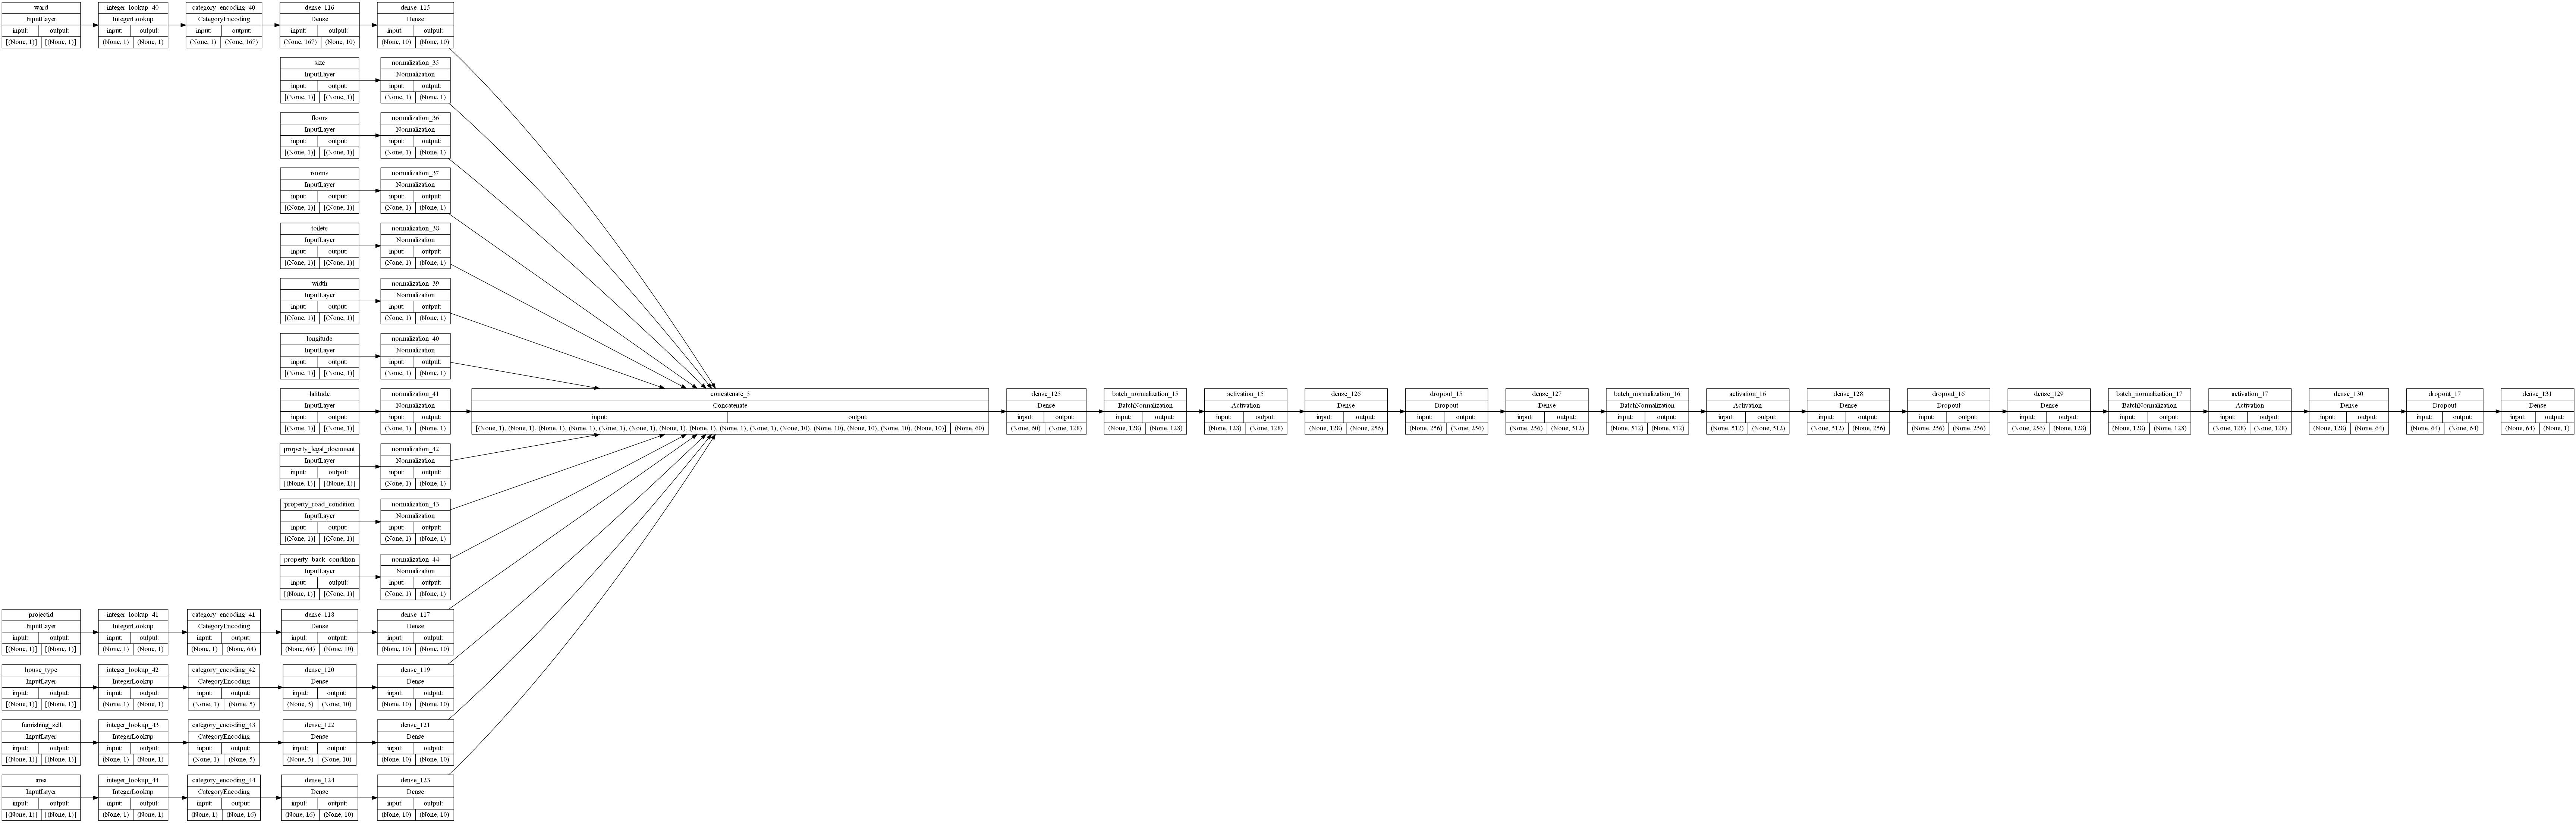

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
import tensorflow_addons as tfa

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError(), tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))])

In [ ]:
# from keras.callbacks import ModelCheckpoint

# filepath = "checkpoint_MLP/checkpoint{epoch}"
# callback = ModelCheckpoint(filepath, save_weights_only=True, monitor='val_r_square', save_best_only=False, save_format='tf')
# callback_best = ModelCheckpoint("checkpoint_MLP/checkpoint_best", save_weights_only=True, monitor='val_r_square', save_best_only=True, mode='max')
# history = model.fit(train_ds, epochs=500, callbacks=[callback, callback_best], batch_size=64, validation_data=val_ds)


history = model.fit(train_ds, epochs=350, batch_size=64, validation_data=val_ds)

Epoch 1/500


D:\Users\Anaconda3\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['area_name', 'price', 'price_string', 'ward_name', 'price_m2'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


206/206 [==============================] - 8s 28ms/step - loss: 0.2834 - mean_absolute_percentage_error: 47.5974 - root_mean_squared_error: 6.3647 - r_square: 0.3456 - val_loss: 0.2112 - val_mean_absolute_percentage_error: 32.6551 - val_root_mean_squared_error: 6.8124 - val_r_square: 0.2562
Epoch 2/500
206/206 [==============================] - 6s 29ms/step - loss: 0.1473 - mean_absolute_percentage_error: 36.6737 - root_mean_squared_error: 5.5930 - r_square: 0.4946 - val_loss: 0.1499 - val_mean_absolute_percentage_error: 28.2574 - val_root_mean_squared_error: 6.0698 - val_r_square: 0.4095
Epoch 3/500
206/206 [==============================] - 6s 30ms/step - loss: 0.1364 - mean_absolute_percentage_error: 34.1569 - root_mean_squared_error: 5.5766 - r_square: 0.4976 - val_loss: 0.1226 - val_mean_absolute_percentage_error: 23.6642 - val_root_mean_squared_error: 5.9193 - val_r_square: 0.4384
Epoch 4/500
206/206 [==============================] - 6s 30ms/step - loss: 0.1272 - mean_absolute_p

In [ ]:
model.evaluate(test_ds)

106/106 [==============================] - 2s 14ms/step - loss: 0.0801 - mean_absolute_percentage_error: 23.3718 - root_mean_squared_error: 3.8818 - r_square: 0.7373


[0.08009375631809235, 23.371768951416016, 3.881808042526245, 0.737273633480072]

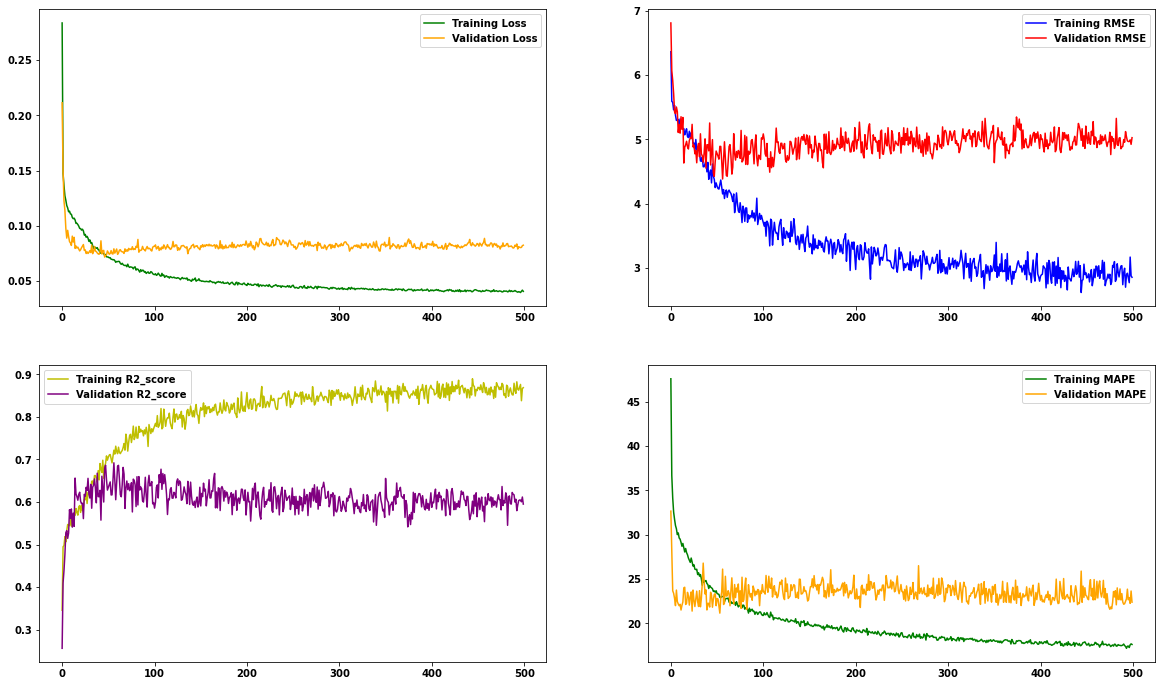

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

def plot_graph(epochs, history=history):

    plt.figure(figsize=(20, 12))

    plt.subplot(2, 2, 1)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(range(epochs), loss, "g", label="Training Loss")
    plt.plot(range(epochs), val_loss, "orange", label="Validation Loss")
    plt.legend()

    plt.subplot(2, 2, 2)
    rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    plt.plot(range(epochs), rmse, "b", label="Training RMSE")
    plt.plot(range(epochs), val_rmse, "r", label="Validation RMSE")
    plt.legend()

    plt.subplot(2, 2, 3)
    r2 = history.history['r_square']
    val_r2 = history.history['val_r_square']
    plt.plot(range(epochs), r2, "y", label="Training R2_score")
    plt.plot(range(epochs), val_r2, "purple", label="Validation R2_score")
    plt.legend()

    plt.subplot(2, 2, 4)
    mape = history.history['mean_absolute_percentage_error']
    val_mape = history.history['val_mean_absolute_percentage_error']
    plt.plot(range(epochs), mape, "green", label="Training MAPE")
    plt.plot(range(epochs), val_mape, "orange", label="Validation MAPE")
    plt.legend()

    plt.figure()
    plt.show()

plot_graph(500)


#### **Cross Validation**

In [3]:
def df_to_dataset(dataframe, shuffle=True, batch_size=64):
    df = dataframe.copy()
    labels = df.pop('price')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

def get_normalization_layer(name, dataset):
    normalizer = layers.Normalization(axis=None)

    feature_ds = dataset.map(lambda x, y: x[name])

    normalizer.adapt(feature_ds)

    return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    feature_ds = dataset.map(lambda x, y: x[name])

    index.adapt(feature_ds)

    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    embedding1 = layers.Dense(10, activation='relu')
    embedding2 = layers.Dense(10, activation='relu')
    # output = layers.Dense(1, activation='relu')

    return lambda feature: embedding1(embedding2(encoder(index(feature))))

In [4]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

In [5]:
def Model(train_ds):    
    
    all_inputs = []
    encoded_features = []

    # Numerical features.
    num_feats = ['size', 'floors', 'rooms', 'toilets', 'width', 'longitude', 'latitude']
    for header in num_feats:
        numeric_col = tf.keras.Input(shape=(1,), name=header)
        normalization_layer = get_normalization_layer(header, train_ds)
        encoded_numeric_col = normalization_layer(numeric_col)
        all_inputs.append(numeric_col)
        encoded_features.append(encoded_numeric_col)


    # Category features
    category_feats = ['ward', 'projectid', 'house_type', 'furnishing_sell', 'area', 'property_legal_document', 'property_road_condition', 'property_back_condition']
    for header in category_feats:
        categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
        encoding_layer = get_category_encoding_layer(name=header, dataset=train_ds, dtype='int', max_tokens=3000)
        encoded_categorical_col = encoding_layer(categorical_col)
        all_inputs.append(categorical_col)
        encoded_features.append(encoded_categorical_col)

    all_features = tf.keras.layers.concatenate(encoded_features)
    x = layers.Dense(128, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(1e-6))(all_features)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dense(256, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(1e-6))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(1e-6))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dense(256, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(1e-6))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(1e-6))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dense(64, activation="relu", kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l1(1e-6))(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, kernel_initializer='glorot_normal', activation='linear')(x)

    model = tf.keras.Model(all_inputs, output)

    model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredLogarithmicError(),
                    metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))])

    return model

In [6]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=22, shuffle=True)

def cross_validation():
    R2 = []
    MAPE = []

    for train_index, test_index in kf.split(datasets):
        train_ds = df_to_dataset(datasets.iloc[train_index])
        test_ds = df_to_dataset(datasets.iloc[test_index], shuffle=False)
        model=Model(train_ds)
        model.fit(train_ds, epochs=300, batch_size=64)
        res = model.evaluate(test_ds)
        R2.append(res[2])
        MAPE.append(res[1])

    return R2, MAPE

In [7]:
#MLP
import numpy as np

R2, MAPE = cross_validation()


<ipython-input-3-a1a2e8003c5e>:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


Epoch 1/300


D:\Users\Anaconda3\lib\site-packages\keras\engine\functional.py:559: UserWarning: Input dict contained keys ['area_name', 'price', 'price_string', 'ward_name', 'price_m2'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


256/256 [==============================] - 16s 23ms/step - loss: 0.2581 - mean_absolute_percentage_error: 45.7911 - r_square: 0.3780
Epoch 2/300
256/256 [==============================] - 6s 23ms/step - loss: 0.1544 - mean_absolute_percentage_error: 37.2079 - r_square: 0.4834
Epoch 3/300
256/256 [==============================] - 6s 24ms/step - loss: 0.1403 - mean_absolute_percentage_error: 35.1095 - r_square: 0.5196
Epoch 4/300
256/256 [==============================] - 6s 24ms/step - loss: 0.1297 - mean_absolute_percentage_error: 33.0029 - r_square: 0.5278
Epoch 5/300
256/256 [==============================] - 6s 24ms/step - loss: 0.1259 - mean_absolute_percentage_error: 32.2536 - r_square: 0.5395
Epoch 6/300
256/256 [==============================] - 6s 24ms/step - loss: 0.1189 - mean_absolute_percentage_error: 31.1217 - r_square: 0.5538
Epoch 7/300
256/256 [==============================] - 6s 24ms/step - loss: 0.1172 - mean_absolute_percentage_error: 30.7400 - r_square: 0.5494
Epo

In [8]:
print('R2 score: ', R2)
print('MAPE: ', MAPE)
print('AVG_R2_score : {}'.format(np.array(R2).mean()))
print('AVG_MAPE : {}'.format(np.array(MAPE).mean()))

R2 score:  [0.7532811760902405, 0.7703408598899841, 0.7169597744941711, 0.7455652952194214, 0.7498295307159424]
MAPE:  [24.402448654174805, 23.095869064331055, 26.90169334411621, 23.574600219726562, 25.4023494720459]
AVG_R2_score : 0.7471953272819519
AVG_MAPE : 24.675392150878906
